# USEFUL NOTES

*   Execute all cells until Confusion Matrix (this one too)
*   <font color='cyan'>Confusion matrix</font> concerns the <font color='cyan'>VALIDATION SET</font>
*   At all experiments, the <font color='cyan'>table</font> which is between the confusion matrix and the learning curve of the model concerns <font color='cyan'>ONLY THE VALIDATION SET</font>
*   <font color='lightgreen'>Execute all the cells below heading FINAL MODEL</font>
*   If you want to execute the cells with the various experiments, please follow the instructions provided below (at each heading) on how to do it.

# LIBRARIES

In [22]:
import pandas as pd
import numpy as np
import nltk
import math
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# CONNECTION WITH GOOGLE DRIVE TO GET THE FILES

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/

/content/drive/MyDrive


In [4]:
import os
path = os.getcwd()
path

'/content/drive/MyDrive'

# <font color='pink'>LOAD THE FILES (here change the name of the file)</font>
### TRAIN_SET AND VALIDATION_SET

In [55]:
#should be in the same directory with the colab notebook
file_to_be_loaded = "vaccine_train_set.csv"
file_to_be_tested = "vaccine_validation_set.csv"     #replace with the test_set.csv

In [56]:
training_df = pd.read_csv(file_to_be_loaded)
validation_df = pd.read_csv(file_to_be_tested)

# <font color='pink'>PRE-PROCESS THE DATA</font>

In [81]:
def clean(df):
  to_be_removed = ['@', '@ ', 'http']
  stop_words = stopwords.words('english') 
  tokenizer = nltk.RegexpTokenizer(r"\w+")

  for row in range(len(df)):
    words_to_be_removed = set()
    r = df['tweet'].values[row].split('\n')
    r = ' '.join(r)
    r = r.split()
    for word in r:    
      for item in to_be_removed:   #word has @, http
        if item in word:
          words_to_be_removed.add(word)
          break
      for w in stop_words:  #word is and, a, an, the etc
        if w == word:
          words_to_be_removed.add(word)
          break
    for word in list(words_to_be_removed):  #remove them from the data
      r = list(filter(lambda x: x != word, r)) 
    df.iloc[row, 1] = ' '.join(r)

    words_to_be_removed = set()
    r = tokenizer.tokenize(df.iloc[row, 1])   #remove all tokens
    df.iloc[row, 1] = ' '.join(r)
    r = df.iloc[row, 1].split()
    for word in r: 
      if word.isdigit():   #remove the numbers
        words_to_be_removed.add(word)
    for word in list(words_to_be_removed):
      r = list(filter(lambda x: x != word, r))
    df.iloc[row, 1] = ' '.join(r)
    #print(r)
  return df

def Stemming(df):
  porter = PorterStemmer()
  for row in range(len(df)):
    r_str = df.iloc[row, 1]
    r_list = r_str.split()
    for word in r_list:
      stem_word = porter.stem(word)
      r_str = r_str.replace(word, stem_word)
    df.iloc[row, 1] = r_str
  return df

def Lemmatization(df):
  wordnet_lemmatizer = WordNetLemmatizer()
  for row in range(len(df)):
    r_str = df.iloc[row, 1]
    r_list = r_str.split()
    for word in r_list:
      stem_word = wordnet_lemmatizer.lemmatize(word, pos="v")
      r_str = r_str.replace(word, stem_word)
    df.iloc[row, 1] = r_str
  return df

In [82]:
def Preprocess_Data(data_set, cleanning=clean, lemmatize=Lemmatization, stem=Stemming):

  if cleanning:
    data_set = clean(data_set)
  if lemmatize:
    data_set = Lemmatization(data_set)
  if stem:
    data_set = Stemming(data_set)
  return data_set


# <font color='pink'>MODEL USING COUNT_VECTORIZER</font>

In [83]:
def CountVectorizer_Model(training_df, validation_df, solver="lbfgs", multi_class = "multinomial", class_weight = "balanced", max_features=800, C=0.5, max_iter=900):
  training_size = []
  f1scores_training = []  
  f1scores_validation = []

  for i in range(10):   #train 10 times increasing the training size by 10%
    total = math.ceil((i+1) * 0.1 * len(training_df.index)) #training size
    stopword_dict = stopwords.words('english')
    vectorizer = CountVectorizer(stop_words = stopword_dict, max_df=5000, max_features = max_features)
    training_data = vectorizer.fit_transform(training_df.tweet.head(total))
    # print(training_data.shape)
    voc_list = (vectorizer.get_feature_names_out())  #list of the features
    training_data = training_data.toarray()
    #print(voc_list)
    validation_data = vectorizer.transform(validation_df['tweet'].values)
    validation_data = validation_data.toarray()
    train_df = pd.DataFrame(training_data, columns = voc_list) #training only tweets
    valid_df = pd.DataFrame(validation_data, columns = voc_list )  #validation only tweets

    X1 = train_df[train_df.columns].values  #true tweets training
    Y1 = training_df['label'].head(total).values #true classes training

    X2 = valid_df[valid_df.columns].values #true tweets validation
    Y2 = validation_df['label'].values  #true classes validation
    
    #scaling the data 
    scaler = StandardScaler()
    X1 = scaler.fit_transform(X1)
    X2 = scaler.transform(X2)

    train_df['label'] = Y1
    valid_df['label'] = Y2

    #create the classifier using Logistic Regression with multi_class = multinomial
    softReg = LogisticRegression(C = C, multi_class = multi_class, solver = solver, class_weight=class_weight, max_iter = max_iter)
    #train the classifier using only data from training set
    softReg.fit(X1,Y1)
    #predict for the training set
    Y1hat = softReg.predict(X1)
    train_df['predict'] = Y1hat
    #predict for the validation set
    Y2hat = softReg.predict(X2)
    valid_df['predict'] = Y2hat

    metrics = Calculate_Metrics(training_df['label'].head(total).values, Y1hat, validation_df['label'].values, Y2hat, average='macro')
    training_size.append(total)
    f1scores_training.append(metrics[4])
    f1scores_validation.append(metrics[5])
  
  Show_Metrics(metrics, 'MACRO')
  #average = weighted for metrics
  metrics = Calculate_Metrics(training_df['label'].head(total).values, Y1hat, validation_df['label'].values, Y2hat)
  Show_Metrics(metrics, 'WEIGHTED')
  #confusion matrix for validation set
  ConfusionMatrix(validation_df['label'].values, Y2hat)
  print(classification_report(validation_df['label'].values, Y2hat, target_names=['0', '1', '2']))
  #learning curve
  Learning_Curve(training_size, f1scores_training, f1scores_validation)

  return

# <font color='pink'>MODEL USING HASHING_VECTORIZER</font>

In [84]:
def HashingVectorizer_Model(training_df, validation_df, n_features=800, C=0.5, max_iter=800, multi_class = 'multinomial', solver = 'lbfgs', class_weight='balanced'):
  training_size = []
  f1scores_training = []
  f1scores_validation = []

  for i in range(10):   #train 10 times increasing the training size by 10%
    total = math.ceil((i+1) * 0.1 * len(training_df.index)) #training size
    stopword_dict = stopwords.words('english')
    vectorizer = HashingVectorizer(stop_words = stopword_dict, n_features = n_features)
    training_data = vectorizer.fit_transform(training_df.tweet.head(total))
    # print(training_data.shape)
    training_data = training_data.toarray()
    #print(voc_list)
    validation_data = vectorizer.transform(validation_df['tweet'].values)
    validation_data = validation_data.toarray()
    train_df = pd.DataFrame(training_data) #training only tweets
    valid_df = pd.DataFrame(validation_data)  #validation only tweets

    X1 = train_df[train_df.columns].values  #true tweets training
    Y1 = training_df['label'].head(total).values #true classes training

    X2 = valid_df[valid_df.columns].values #true tweets validation
    Y2 = validation_df['label'].values  #true classes validation
    
    #scaling the data 
    scaler = StandardScaler()
    X1 = scaler.fit_transform(X1)
    X2 = scaler.transform(X2)

    train_df['label'] = Y1
    valid_df['label'] = Y2

    #create the classifier using Logistic Regression with multi_class = multinomial
    softReg = LogisticRegression(C = C, multi_class = multi_class, solver = solver, class_weight=class_weight, max_iter = max_iter)
    #train the classifier using only data from training set
    softReg.fit(X1,Y1)
    #predict for the training set
    Y1hat = softReg.predict(X1)
    train_df['predict'] = Y1hat
    #predict for the validation set
    Y2hat = softReg.predict(X2)
    valid_df['predict'] = Y2hat

    metrics = Calculate_Metrics(training_df['label'].head(total).values, Y1hat, validation_df['label'].values, Y2hat, average = 'macro')
    training_size.append(total)
    f1scores_training.append(metrics[4])
    f1scores_validation.append(metrics[5])
  
  Show_Metrics(metrics, 'MACRO')

  #average = weighted for metrics
  metrics = Calculate_Metrics(training_df['label'].head(total).values, Y1hat, validation_df['label'].values, Y2hat)
  Show_Metrics(metrics, 'WEIGHTED')
  #confusion matrix for validation set
  ConfusionMatrix(validation_df['label'].values, Y2hat)
  print(classification_report(validation_df['label'].values, Y2hat, target_names=['0', '1', '2']))
  #learning curve
  Learning_Curve(training_size, f1scores_training, f1scores_validation)
  return

# <font color='pink'>MODEL USING TFIDF_VECTORIZER</font>

In [85]:
def TfidfVectorizer_Model(training_df, validation_df, multi_class='multinomial', solver='lbfgs', class_weight='balanced', max_features=1000, C=0.5, max_iter=800):
  training_size = []
  f1scores_training = []
  f1scores_validation = []

  for i in range(10):   #train 10 times increasing the training size by 10%
    total = math.ceil((i+1) * 0.1 * len(training_df.index)) #training size
    stopword_dict = stopwords.words('english')
    vectorizer = TfidfVectorizer(stop_words = stopword_dict, max_features = max_features, max_df=5000)
    training_data = vectorizer.fit_transform(training_df.tweet.head(total))
    # print(training_data.shape)
    voc_list = (vectorizer.get_feature_names_out())  #list of the features
    training_data = training_data.toarray()
    #print(voc_list)
    validation_data = vectorizer.transform(validation_df['tweet'].values)
    validation_data = validation_data.toarray()
    train_df = pd.DataFrame(training_data, columns = voc_list) #training only tweets
    valid_df = pd.DataFrame(validation_data, columns = voc_list )  #validation only tweets

    X1 = train_df[train_df.columns].values  #true tweets training
    Y1 = training_df['label'].head(total).values #true classes training

    X2 = valid_df[valid_df.columns].values #true tweets validation
    Y2 = validation_df['label'].values  #true classes validation
    
    #scaling the data 
    scaler = StandardScaler()
    X1 = scaler.fit_transform(X1)
    X2 = scaler.transform(X2)

    train_df['label'] = Y1
    valid_df['label'] = Y2

    #create the classifier using Logistic Regression with multi_class = multinomial
    softReg = LogisticRegression(C = C, multi_class = multi_class, solver = solver, class_weight=class_weight, max_iter = max_iter)
    #train the classifier using only data from training set
    softReg.fit(X1,Y1)
    #predict for the training set
    Y1hat = softReg.predict(X1)
    train_df['predict'] = Y1hat
    #predict for the validation set
    Y2hat = softReg.predict(X2)
    valid_df['predict'] = Y2hat

    metrics = Calculate_Metrics(training_df['label'].head(total).values, Y1hat, validation_df['label'].values, Y2hat, average='macro')
    training_size.append(total)
    f1scores_training.append(metrics[4])
    f1scores_validation.append(metrics[5])
    
  Show_Metrics(metrics, 'MACRO')

  #average = weighted for metrics
  metrics = Calculate_Metrics(training_df['label'].head(total).values, Y1hat, validation_df['label'].values, Y2hat)
  Show_Metrics(metrics, 'WEIGHTED')
  #confusion matrix for validation set
  ConfusionMatrix(validation_df['label'].values, Y2hat)
  print(classification_report(validation_df['label'].values, Y2hat, target_names=['0', '1', '2']))
  #learning curve
  Learning_Curve(training_size, f1scores_training, f1scores_validation)

  return


# <font color='cyan'>PRECISION - RECALL - F1SCORE - ACCURACY</font>

In [86]:
def Calculate_Metrics(training_true, training_predicted, validation_true, validation_predicted, average = 'weighted'):

  metrics = []  
  precision_training = precision_score(training_true, training_predicted, average = average)
  metrics.append(precision_training)
  precision_validation = precision_score(validation_true, validation_predicted, average = average)
  metrics.append(precision_validation)
  recall_training = recall_score(training_true, training_predicted, average = average)
  metrics.append(recall_training)
  recall_validation = recall_score(validation_true, validation_predicted, average = average)
  metrics.append(recall_validation)  
  f1_training = f1_score(training_true, training_predicted, average = average)
  metrics.append(f1_training)  
  f1_validation = f1_score(validation_true, validation_predicted, average = average)
  metrics.append(f1_validation)  
  accuracy_training = accuracy_score(training_true, training_predicted)
  metrics.append(accuracy_training)  
  accuracy_validation = accuracy_score(validation_true, validation_predicted)
  metrics.append(accuracy_validation)
  return metrics 


def Show_Metrics(metrics, average):   #print the dataframes with the metrics
  
  data = {'PRECISION': metrics[0:2], 'RECALL':metrics[2:4], 'F1_SCORE':metrics[4:6], 'ACCURACY':metrics[6:8]}
  ROWS = ['TRAINING SET' , 'VALIDATION SET']
  df = pd.DataFrame(data, index = ROWS)
  print(average)
  display(df)
  print('\n')
  return

# <font color='cyan'>LEARNING CURVES</font>
### F1SCORE FOR TRAINING AND VALIDATION SETS IN RELATION TO TRAINING SET'S SIZE

In [87]:
def Learning_Curve(training_size, f1_training, f1_validation):  #create the learning curve
  plt.plot(training_size, f1_training, 'm')
  plt.plot(training_size, f1_validation, 'c')
  plt.title("Learning Curve")
  plt.xlabel("Training Size")
  plt.ylabel("F1 Score")
  plt.legend(["training", "validation"], loc ="lower right")
  plt.show()
  return

# <font color='cyan'>CONFUSION MATRIX</font>

In [88]:
def ConfusionMatrix(true, predicted):  #create and display the confusion matrix
  C = confusion_matrix(true, predicted)
  confusionMatrix = pd.DataFrame(data = C, index=['neutral(0), true','negative(1), true','positive(2), true'], columns = ['neutral(0), predicted','negative(1), predicted','positive(2), predicted'])
  disp = ConfusionMatrixDisplay(confusion_matrix = C)
  disp.plot()
  plt.show()
  print('\n')
  return

# <font color='yellow'>FINAL MODEL</font> 

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.723476,0.671172,0.688146,0.747809
VALIDATION SET,0.657973,0.633880,0.643273,0.701578




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.744413,0.747809,0.742159,0.747809
VALIDATION SET,0.696617,0.701578,0.697943,0.701578


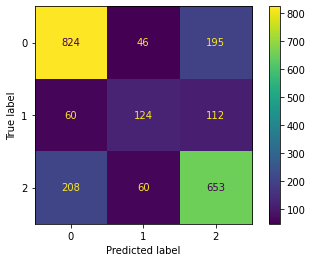



              precision    recall  f1-score   support

           0       0.75      0.77      0.76      1065
           1       0.54      0.42      0.47       296
           2       0.68      0.71      0.69       921

    accuracy                           0.70      2282
   macro avg       0.66      0.63      0.64      2282
weighted avg       0.70      0.70      0.70      2282



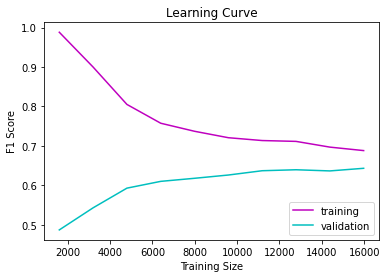

In [89]:
training_df = Preprocess_Data(training_df, stem=None)
validation_df = Preprocess_Data(validation_df, stem=None)
CountVectorizer_Model(training_df, validation_df, class_weight=None)

# <font color='yellow'>EXPERIMENTS</font>

# <font color='lightgreen'>TEST THE VARIOUS MODELS USING COUNT_VECTORIZER</font>

#### With preprocessing of the data (Only cleaning and lemmatization). 
If needed to be executed, heading "LOAD THE FILES" should be executed (please execute it), then heading "PRE-PROCESS THE DATA" (please execute it) and then the respective model with the desirable parameters

In [57]:
training_df = Preprocess_Data(training_df, stem=None)
validation_df = Preprocess_Data(validation_df, stem=None)

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.951183,0.967273,0.958782,0.961317
VALIDATION SET,0.532862,0.548632,0.537082,0.586328




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.961877,0.961317,0.961390,0.961317
VALIDATION SET,0.602166,0.586328,0.592471,0.586328


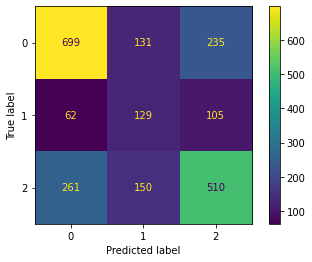

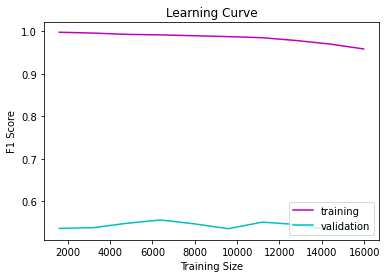

In [ ]:
CountVectorizer_Model(training_df, validation_df, max_features=7000) 

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.600429,0.631498,0.588811,0.627128
VALIDATION SET,0.601998,0.636597,0.592560,0.629273




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.693913,0.627128,0.645735,0.627128
VALIDATION SET,0.693736,0.629273,0.647224,0.629273


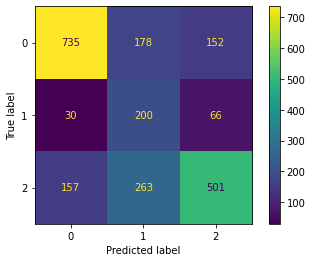



              precision    recall  f1-score   support

           0       0.80      0.69      0.74      1065
           1       0.31      0.68      0.43       296
           2       0.70      0.54      0.61       921

    accuracy                           0.63      2282
   macro avg       0.60      0.64      0.59      2282
weighted avg       0.69      0.63      0.65      2282



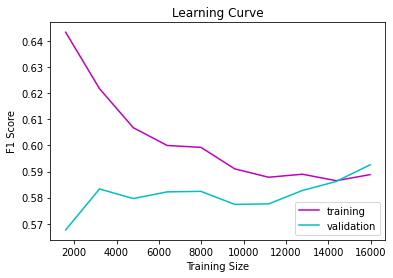

In [58]:
CountVectorizer_Model(training_df, validation_df, max_features=100) 

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.679397,0.727719,0.687111,0.721332
VALIDATION SET,0.639896,0.680823,0.645880,0.682296




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.757238,0.721332,0.731272,0.721332
VALIDATION SET,0.716154,0.682296,0.692121,0.682296


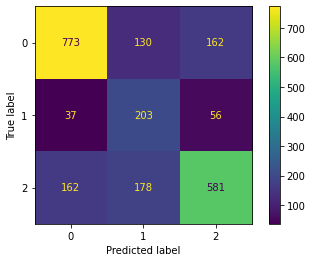



              precision    recall  f1-score   support

           0       0.80      0.73      0.76      1065
           1       0.40      0.69      0.50       296
           2       0.73      0.63      0.68       921

    accuracy                           0.68      2282
   macro avg       0.64      0.68      0.65      2282
weighted avg       0.72      0.68      0.69      2282



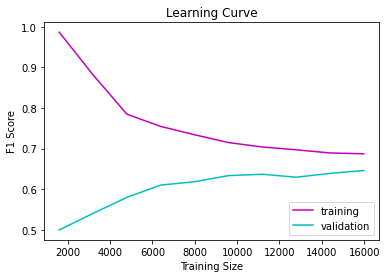

In [59]:
CountVectorizer_Model(training_df, validation_df) 

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.722267,0.671067,0.687747,0.747997
VALIDATION SET,0.662181,0.638246,0.647695,0.704207




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.744343,0.747997,0.742328,0.747997
VALIDATION SET,0.699472,0.704207,0.700747,0.704207


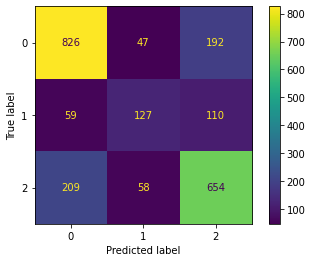



              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1065
           1       0.55      0.43      0.48       296
           2       0.68      0.71      0.70       921

    accuracy                           0.70      2282
   macro avg       0.66      0.64      0.65      2282
weighted avg       0.70      0.70      0.70      2282



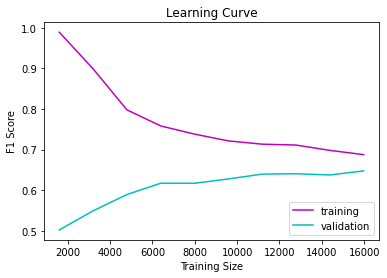

In [35]:
CountVectorizer_Model(training_df, validation_df, class_weight=None)

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.705429,0.758462,0.716592,0.746933
VALIDATION SET,0.630074,0.666724,0.637567,0.675285




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.777648,0.746933,0.754932,0.746933
VALIDATION SET,0.702213,0.675285,0.683516,0.675285


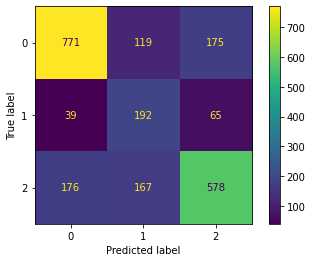

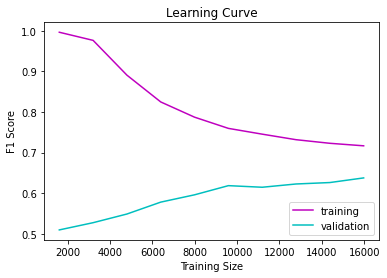

In [ ]:
CountVectorizer_Model(training_df, validation_df, max_features=1200)


#### Without any preprocessing of the data
If needed to be executed, heading "LOAD THE FILES" should be executed (so that the data be unchanged), (please execute it), and then the respective model with the desirable parameters



MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.681332,0.728787,0.688761,0.724211
VALIDATION SET,0.629251,0.665598,0.636853,0.674847




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.759920,0.724211,0.734119,0.724211
VALIDATION SET,0.701631,0.674847,0.683148,0.674847


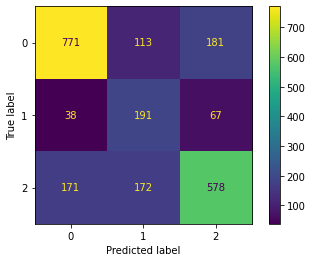



              precision    recall  f1-score   support

           0       0.79      0.72      0.75      1065
           1       0.40      0.65      0.49       296
           2       0.70      0.63      0.66       921

    accuracy                           0.67      2282
   macro avg       0.63      0.67      0.64      2282
weighted avg       0.70      0.67      0.68      2282



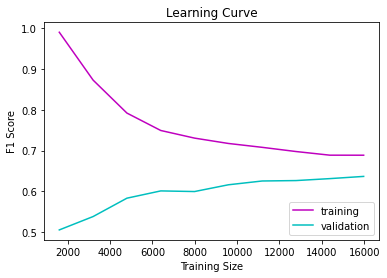

In [42]:
CountVectorizer_Model(training_df, validation_df)

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.728027,0.677206,0.694238,0.751377
VALIDATION SET,0.674810,0.638251,0.651312,0.708151




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.748011,0.751377,0.746112,0.751377
VALIDATION SET,0.703606,0.708151,0.703630,0.708151


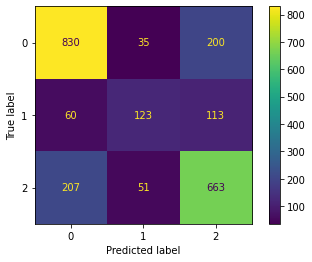



              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1065
           1       0.59      0.42      0.49       296
           2       0.68      0.72      0.70       921

    accuracy                           0.71      2282
   macro avg       0.67      0.64      0.65      2282
weighted avg       0.70      0.71      0.70      2282



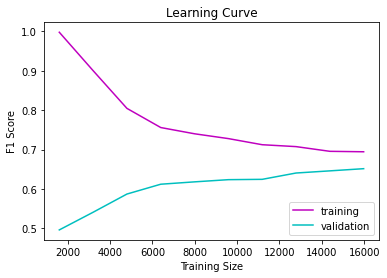

In [43]:
CountVectorizer_Model(training_df, validation_df, C=5, class_weight=None)

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.740190,0.692313,0.709123,0.761705
VALIDATION SET,0.672297,0.638938,0.651185,0.706836




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.759017,0.761705,0.757292,0.761705
VALIDATION SET,0.702443,0.706836,0.702719,0.706836


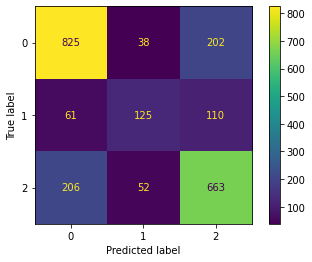

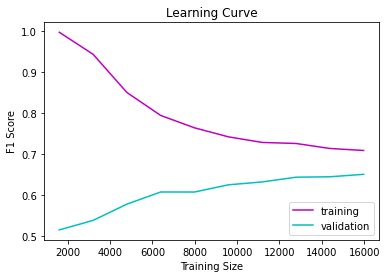

In [ ]:
CountVectorizer_Model(training_df, validation_df, class_weight=None)

#### With full preprocessing of the data
If needed to be executed, heading "LOAD THE FILES" should be executed (please execute it), then heading "PRE-PROCESS THE DATA" (please execute it) and then the respective model with the desirable parameters

In [48]:
training_df = Preprocess_Data(training_df)
validation_df = Preprocess_Data(validation_df)

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.658449,0.705285,0.666790,0.699424
VALIDATION SET,0.614157,0.653757,0.620179,0.655565




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.730997,0.699424,0.707898,0.699424
VALIDATION SET,0.687780,0.655565,0.664935,0.655565


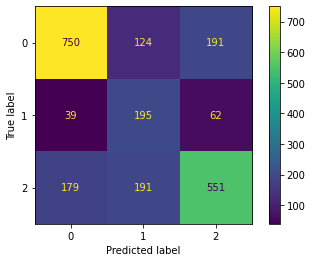



              precision    recall  f1-score   support

           0       0.77      0.70      0.74      1065
           1       0.38      0.66      0.48       296
           2       0.69      0.60      0.64       921

    accuracy                           0.66      2282
   macro avg       0.61      0.65      0.62      2282
weighted avg       0.69      0.66      0.66      2282



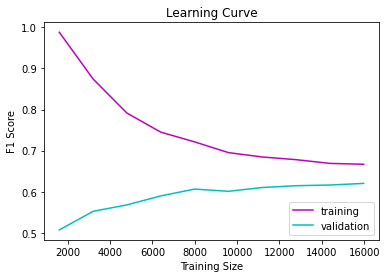

In [49]:
CountVectorizer_Model(training_df, validation_df) 

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.707124,0.656781,0.673496,0.730721
VALIDATION SET,0.655110,0.625970,0.637202,0.688869




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.726829,0.730721,0.725182,0.730721
VALIDATION SET,0.684373,0.688869,0.685173,0.688869


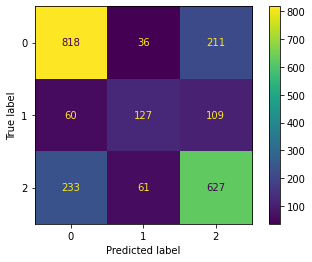



              precision    recall  f1-score   support

           0       0.74      0.77      0.75      1065
           1       0.57      0.43      0.49       296
           2       0.66      0.68      0.67       921

    accuracy                           0.69      2282
   macro avg       0.66      0.63      0.64      2282
weighted avg       0.68      0.69      0.69      2282



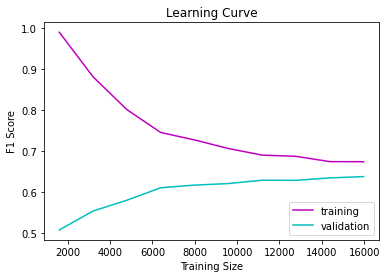

In [50]:
CountVectorizer_Model(training_df, validation_df, class_weight=None) 

# <font color='lightgreen'>TEST THE VARIOUS MODELS USING HASHING_VECTORIZER</font>

#### With preprocessing of the data (Only cleaning and lemmatization). 

If needed to be executed, heading "LOAD THE FILES" should be executed (please execute it), then heading "PRE-PROCESS THE DATA" (please execute it) and then the respective model with the desirable parameters

In [ ]:
training_df = Preprocess_Data(training_df, stem=None)
validation_df = Preprocess_Data(validation_df, stem=None)

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.649360,0.694250,0.656008,0.690473
VALIDATION SET,0.607811,0.643085,0.610559,0.649869




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.725877,0.690473,0.700452,0.690473
VALIDATION SET,0.689149,0.649869,0.662066,0.649869


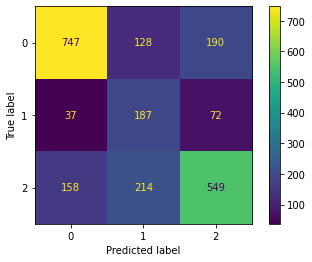



              precision    recall  f1-score   support

           0       0.79      0.70      0.74      1065
           1       0.35      0.63      0.45       296
           2       0.68      0.60      0.63       921

    accuracy                           0.65      2282
   macro avg       0.61      0.64      0.61      2282
weighted avg       0.69      0.65      0.66      2282



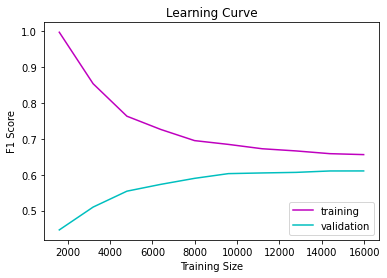

In [60]:
HashingVectorizer_Model(training_df, validation_df)

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.696207,0.648791,0.664209,0.725839
VALIDATION SET,0.650360,0.620351,0.631101,0.692813




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.721360,0.725839,0.720038,0.725839
VALIDATION SET,0.687488,0.692813,0.688274,0.692813


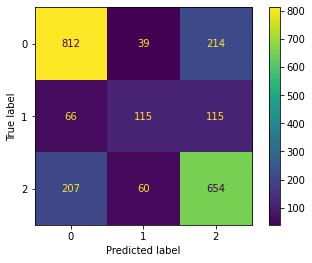



              precision    recall  f1-score   support

           0       0.75      0.76      0.76      1065
           1       0.54      0.39      0.45       296
           2       0.67      0.71      0.69       921

    accuracy                           0.69      2282
   macro avg       0.65      0.62      0.63      2282
weighted avg       0.69      0.69      0.69      2282



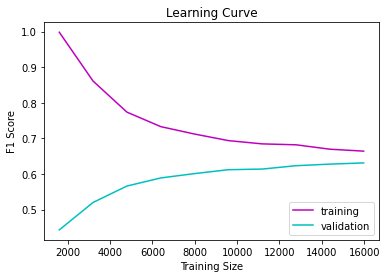

In [61]:
HashingVectorizer_Model(training_df, validation_df, class_weight=None)

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.688918,0.741270,0.699499,0.729407
VALIDATION SET,0.599278,0.625877,0.599660,0.645925




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.760563,0.729407,0.737491,0.729407
VALIDATION SET,0.686309,0.645925,0.659577,0.645925


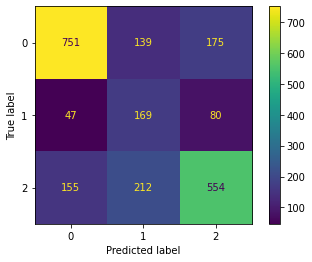



              precision    recall  f1-score   support

           0       0.79      0.71      0.74      1065
           1       0.33      0.57      0.41       296
           2       0.68      0.60      0.64       921

    accuracy                           0.65      2282
   macro avg       0.60      0.63      0.60      2282
weighted avg       0.69      0.65      0.66      2282



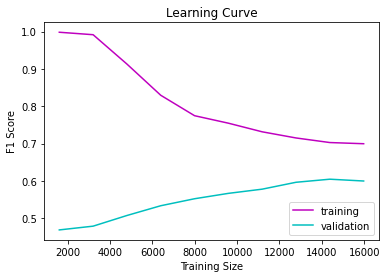

In [62]:
HashingVectorizer_Model(training_df, validation_df, n_features=1300)

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.549100,0.577289,0.537024,0.572421
VALIDATION SET,0.542155,0.565929,0.530031,0.567046




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.636351,0.572421,0.590052,0.572421
VALIDATION SET,0.630037,0.567046,0.585352,0.567046


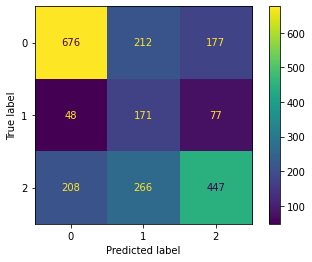



              precision    recall  f1-score   support

           0       0.73      0.63      0.68      1065
           1       0.26      0.58      0.36       296
           2       0.64      0.49      0.55       921

    accuracy                           0.57      2282
   macro avg       0.54      0.57      0.53      2282
weighted avg       0.63      0.57      0.59      2282



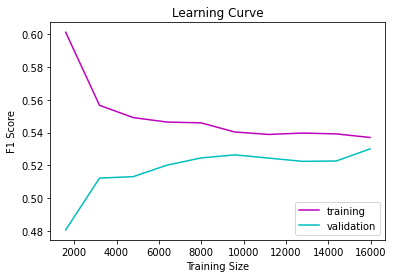

In [63]:
HashingVectorizer_Model(training_df, validation_df, n_features=100)

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.662085,0.709838,0.669550,0.702491
VALIDATION SET,0.605862,0.639021,0.607739,0.648116




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.737993,0.702491,0.712238,0.702491
VALIDATION SET,0.688858,0.648116,0.661074,0.648116


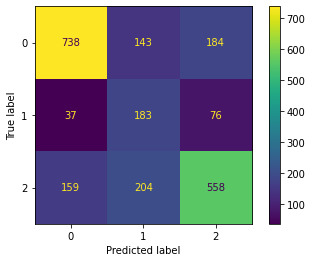



              precision    recall  f1-score   support

           0       0.79      0.69      0.74      1065
           1       0.35      0.62      0.44       296
           2       0.68      0.61      0.64       921

    accuracy                           0.65      2282
   macro avg       0.61      0.64      0.61      2282
weighted avg       0.69      0.65      0.66      2282



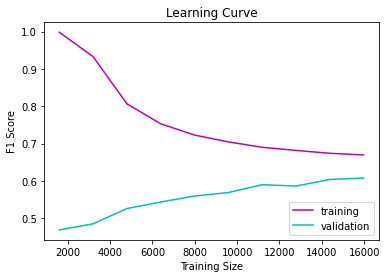

In [64]:
HashingVectorizer_Model(training_df, validation_df, 1000, 1)

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.974163,0.971220,0.972673,0.971645
VALIDATION SET,0.506133,0.517853,0.510054,0.558720




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.971688,0.971645,0.971656,0.971645
VALIDATION SET,0.569758,0.558720,0.563318,0.558720


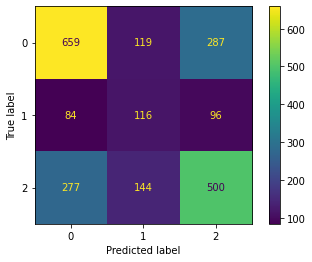

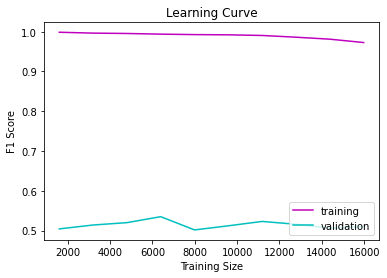

In [ ]:
HashingVectorizer_Model(training_df, validation_df, n_features=10000, class_weight=None)

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.649298,0.694198,0.655965,0.690411
VALIDATION SET,0.607460,0.642772,0.610228,0.649430




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.725763,0.690411,0.700372,0.690411
VALIDATION SET,0.688709,0.649430,0.661626,0.649430


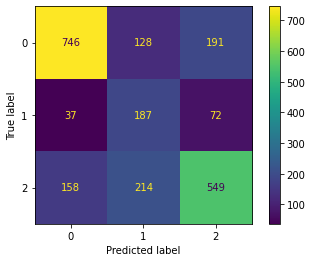



              precision    recall  f1-score   support

           0       0.79      0.70      0.74      1065
           1       0.35      0.63      0.45       296
           2       0.68      0.60      0.63       921

    accuracy                           0.65      2282
   macro avg       0.61      0.64      0.61      2282
weighted avg       0.69      0.65      0.66      2282



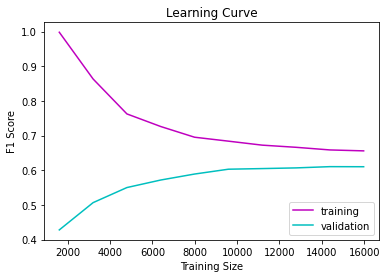

In [65]:
HashingVectorizer_Model(training_df, validation_df, C=5)

#### Without any preprocessing of the data
If needed to be executed, heading "LOAD THE FILES" should be executed (so that the data be unchanged), (please execute it), and then the respective model with the desirable parameters.

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.645678,0.690777,0.650761,0.685466
VALIDATION SET,0.589836,0.623339,0.591478,0.630149




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.724277,0.685466,0.696248,0.685466
VALIDATION SET,0.670919,0.630149,0.642905,0.630149


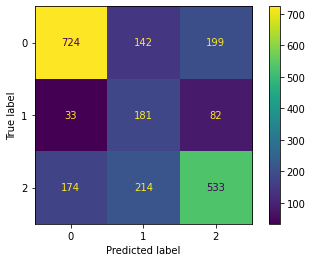



              precision    recall  f1-score   support

           0       0.78      0.68      0.73      1065
           1       0.34      0.61      0.43       296
           2       0.65      0.58      0.61       921

    accuracy                           0.63      2282
   macro avg       0.59      0.62      0.59      2282
weighted avg       0.67      0.63      0.64      2282



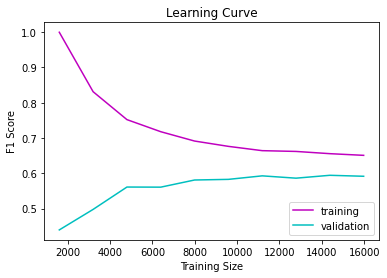

In [44]:
HashingVectorizer_Model(training_df, validation_df)

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.687937,0.641267,0.656335,0.719454
VALIDATION SET,0.634935,0.606202,0.616474,0.678791




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.714381,0.719454,0.713383,0.719454
VALIDATION SET,0.673220,0.678791,0.674207,0.678791


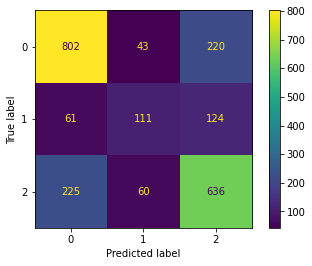



              precision    recall  f1-score   support

           0       0.74      0.75      0.75      1065
           1       0.52      0.38      0.44       296
           2       0.65      0.69      0.67       921

    accuracy                           0.68      2282
   macro avg       0.63      0.61      0.62      2282
weighted avg       0.67      0.68      0.67      2282



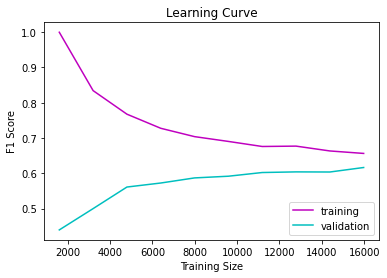

In [45]:
HashingVectorizer_Model(training_df, validation_df, class_weight=None)

#### With full preprocessing of the data. 
If needed to be executed, heading "LOAD THE FILES" should be executed (please execute it), then heading "PRE-PROCESS THE DATA" (please execute it) and then the respective model with the desirable parameters

In [ ]:
training_df = Preprocess_Data(training_df)
validation_df = Preprocess_Data(validation_df)

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.649179,0.694484,0.654332,0.689096
VALIDATION SET,0.590246,0.626996,0.591685,0.628396




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.728246,0.689096,0.700035,0.689096
VALIDATION SET,0.670897,0.628396,0.641102,0.628396


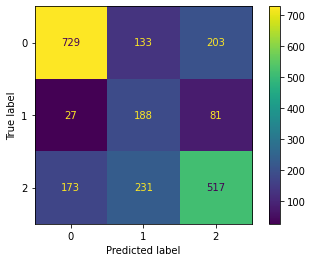



              precision    recall  f1-score   support

           0       0.78      0.68      0.73      1065
           1       0.34      0.64      0.44       296
           2       0.65      0.56      0.60       921

    accuracy                           0.63      2282
   macro avg       0.59      0.63      0.59      2282
weighted avg       0.67      0.63      0.64      2282



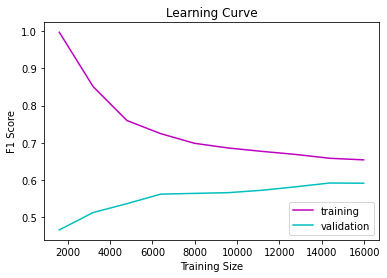

In [51]:
HashingVectorizer_Model(training_df, validation_df)

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.690465,0.642101,0.657246,0.722584
VALIDATION SET,0.625461,0.599001,0.608564,0.670465




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.717616,0.722584,0.716207,0.722584
VALIDATION SET,0.665777,0.670465,0.666444,0.670465


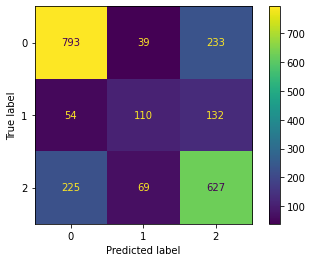



              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1065
           1       0.50      0.37      0.43       296
           2       0.63      0.68      0.66       921

    accuracy                           0.67      2282
   macro avg       0.63      0.60      0.61      2282
weighted avg       0.67      0.67      0.67      2282



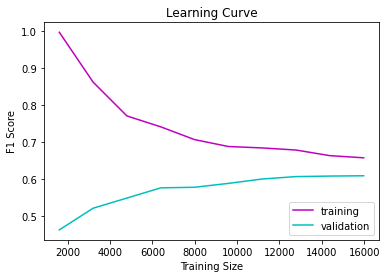

In [52]:
HashingVectorizer_Model(training_df, validation_df, class_weight=None)

# <font color='lightgreen'>TEST THE VARIOUS MODELS USING TFIDF_VECTORIZER</font>

#### With preprocessing of the data (Only cleaning and lemmatization). 
If needed to be executed, heading "LOAD THE FILES" should be executed (please execute it), then heading "PRE-PROCESS THE DATA" (please execute it) and then the respective model with the desirable parameters

In [ ]:
training_df = Preprocess_Data(training_df, stem=None)
validation_df = Preprocess_Data(validation_df, stem=None)

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.688887,0.740394,0.696960,0.729407
VALIDATION SET,0.626186,0.665428,0.633319,0.668712




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.766828,0.729407,0.739474,0.729407
VALIDATION SET,0.699689,0.668712,0.678085,0.668712


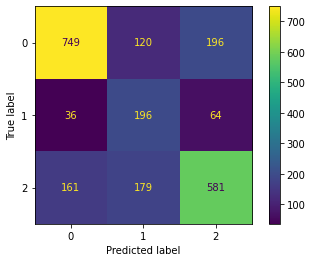



              precision    recall  f1-score   support

           0       0.79      0.70      0.74      1065
           1       0.40      0.66      0.50       296
           2       0.69      0.63      0.66       921

    accuracy                           0.67      2282
   macro avg       0.63      0.67      0.63      2282
weighted avg       0.70      0.67      0.68      2282



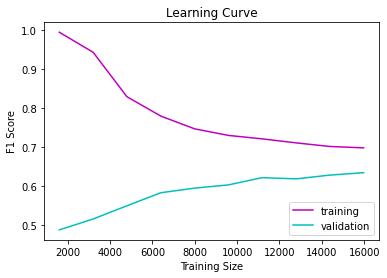

In [66]:
TfidfVectorizer_Model(training_df, validation_df) 

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.726757,0.687746,0.701883,0.756885
VALIDATION SET,0.651907,0.629722,0.638403,0.696757




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.753584,0.756885,0.752842,0.756885
VALIDATION SET,0.692354,0.696757,0.693468,0.696757


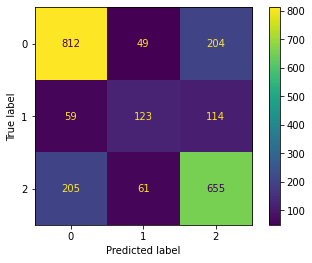



              precision    recall  f1-score   support

           0       0.75      0.76      0.76      1065
           1       0.53      0.42      0.47       296
           2       0.67      0.71      0.69       921

    accuracy                           0.70      2282
   macro avg       0.65      0.63      0.64      2282
weighted avg       0.69      0.70      0.69      2282



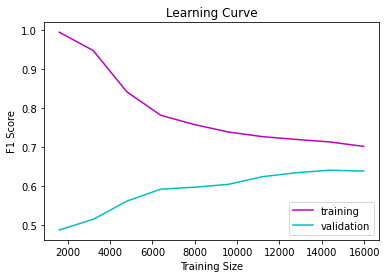

In [67]:
TfidfVectorizer_Model(training_df, validation_df, class_weight=None) 

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.603741,0.635019,0.595738,0.634827
VALIDATION SET,0.591693,0.626122,0.585660,0.621823




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.697137,0.634827,0.653464,0.634827
VALIDATION SET,0.680772,0.621823,0.639090,0.621823


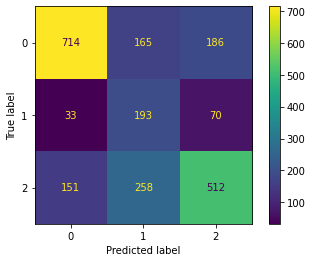



              precision    recall  f1-score   support

           0       0.80      0.67      0.73      1065
           1       0.31      0.65      0.42       296
           2       0.67      0.56      0.61       921

    accuracy                           0.62      2282
   macro avg       0.59      0.63      0.59      2282
weighted avg       0.68      0.62      0.64      2282



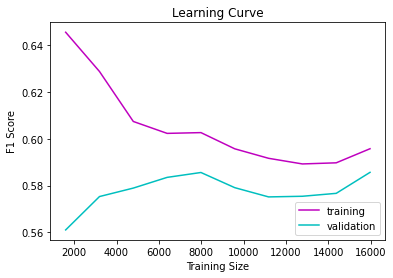

In [68]:
TfidfVectorizer_Model(training_df, validation_df, max_features=100) 

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.703706,0.757182,0.714549,0.744805
VALIDATION SET,0.627095,0.665171,0.633683,0.670903




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.776821,0.744805,0.753153,0.744805
VALIDATION SET,0.702368,0.670903,0.680559,0.670903


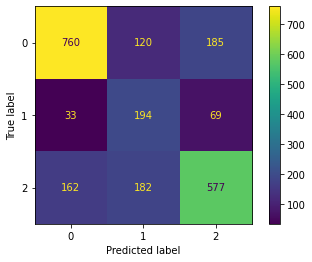



              precision    recall  f1-score   support

           0       0.80      0.71      0.75      1065
           1       0.39      0.66      0.49       296
           2       0.69      0.63      0.66       921

    accuracy                           0.67      2282
   macro avg       0.63      0.67      0.63      2282
weighted avg       0.70      0.67      0.68      2282



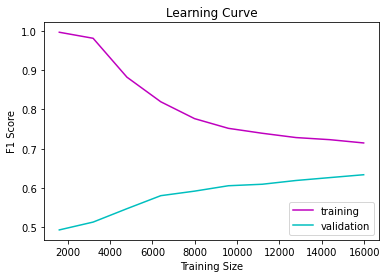

In [69]:
TfidfVectorizer_Model(training_df, validation_df, max_features=1200) 

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.688903,0.740336,0.69698,0.729469
VALIDATION SET,0.624757,0.663627,0.63185,0.667397




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.766857,0.729469,0.739538,0.729469
VALIDATION SET,0.698227,0.667397,0.676766,0.667397


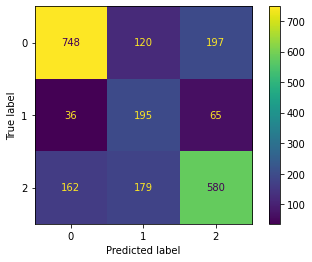



              precision    recall  f1-score   support

           0       0.79      0.70      0.74      1065
           1       0.39      0.66      0.49       296
           2       0.69      0.63      0.66       921

    accuracy                           0.67      2282
   macro avg       0.62      0.66      0.63      2282
weighted avg       0.70      0.67      0.68      2282



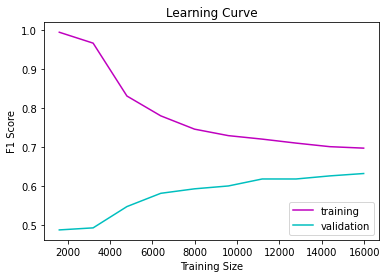

In [70]:
TfidfVectorizer_Model(training_df, validation_df, C=5) 

#### Without any preprocessing of the data
If needed to be executed, heading "LOAD THE FILES" should be executed (so that the data be unchanged), (please execute it), and then the respective model with the desirable parameters.

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.689616,0.739036,0.698125,0.731910
VALIDATION SET,0.630484,0.667164,0.636389,0.675285




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.767260,0.731910,0.741694,0.731910
VALIDATION SET,0.707922,0.675285,0.685511,0.675285


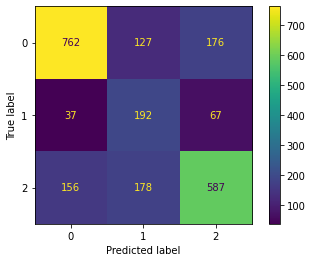



              precision    recall  f1-score   support

           0       0.80      0.72      0.75      1065
           1       0.39      0.65      0.48       296
           2       0.71      0.64      0.67       921

    accuracy                           0.68      2282
   macro avg       0.63      0.67      0.64      2282
weighted avg       0.71      0.68      0.69      2282



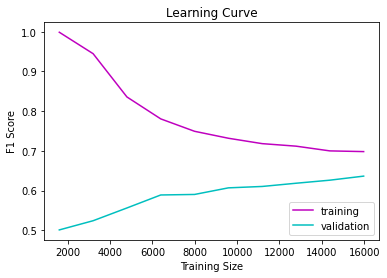

In [46]:
TfidfVectorizer_Model(training_df, validation_df)

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.736561,0.696315,0.711045,0.763082
VALIDATION SET,0.669860,0.643621,0.653908,0.706836




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.760435,0.763082,0.759353,0.763082
VALIDATION SET,0.703101,0.706836,0.703719,0.706836


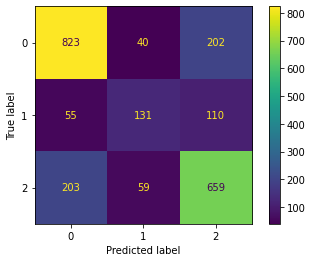



              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1065
           1       0.57      0.44      0.50       296
           2       0.68      0.72      0.70       921

    accuracy                           0.71      2282
   macro avg       0.67      0.64      0.65      2282
weighted avg       0.70      0.71      0.70      2282



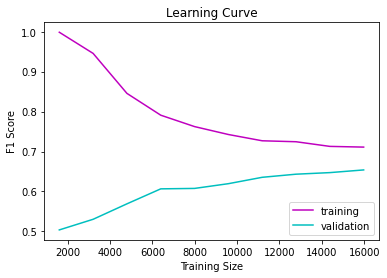

In [47]:
TfidfVectorizer_Model(training_df, validation_df, class_weight = None)

#### With full preprocessing of the data
If needed to be executed, heading "LOAD THE FILES" should be executed (please execute it), then heading "PRE-PROCESS THE DATA" (please execute it) and then the respective model with the desirable parameters

In [ ]:
training_df = Preprocess_Data(training_df)
validation_df = Preprocess_Data(validation_df)

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.667436,0.718022,0.676065,0.706685
VALIDATION SET,0.601528,0.640293,0.607179,0.641543




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.740777,0.706685,0.715650,0.706685
VALIDATION SET,0.675239,0.641543,0.651602,0.641543


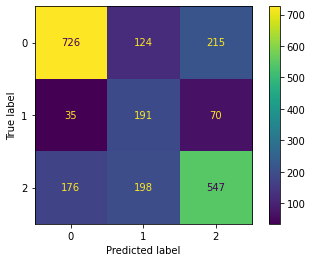



              precision    recall  f1-score   support

           0       0.77      0.68      0.73      1065
           1       0.37      0.65      0.47       296
           2       0.66      0.59      0.62       921

    accuracy                           0.64      2282
   macro avg       0.60      0.64      0.61      2282
weighted avg       0.68      0.64      0.65      2282



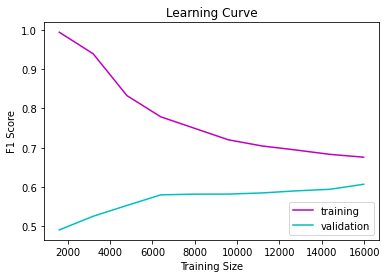

In [53]:
TfidfVectorizer_Model(training_df, validation_df) 

MACRO


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.713221,0.672782,0.687514,0.739922
VALIDATION SET,0.643979,0.620735,0.629961,0.683611




WEIGHTED


,PRECISION,RECALL,F1_SCORE,ACCURACY
TRAINING SET,0.736300,0.739922,0.735761,0.739922
VALIDATION SET,0.679473,0.683611,0.680498,0.683611


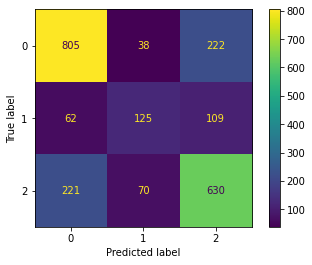



              precision    recall  f1-score   support

           0       0.74      0.76      0.75      1065
           1       0.54      0.42      0.47       296
           2       0.66      0.68      0.67       921

    accuracy                           0.68      2282
   macro avg       0.64      0.62      0.63      2282
weighted avg       0.68      0.68      0.68      2282



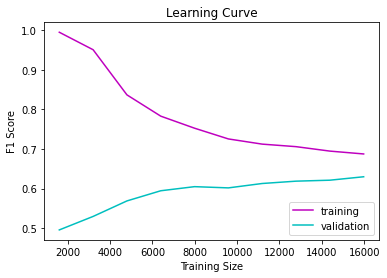

In [54]:
TfidfVectorizer_Model(training_df, validation_df, class_weight = None) 